# Notebook for testing flux limits

### Setup

In [97]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from astropy.cosmology import FlatLambdaCDM

file = pd.read_csv('../DATA/ZFOURGE/CDFS/CDFS_MAIN.csv')
df = pd.DataFrame(file) # 30,911 galaxies
df = df[df['Use'] == 1] # 13,299 galaxies
df = df[df['FKs'] > 0] # 12,676 galaxies

z_bins = [(0, 1), (1, 2), (2, 3), (3, 4), (4, 5), (5, 6)]
mag_lim = 25.9
survey_area = 0.03556 # survey area in square degrees

### Ks Band Distribution

Used to mask the magnitude limit in AB space. The masked values are then used for the Ks band Luminosity

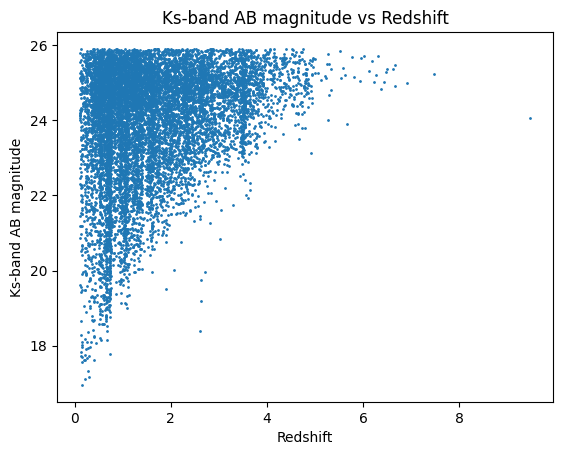

In [98]:
z = df['zpk']
f = df['FKs'] # Ks-band flux

mag_ab = 25 - 2.5*np.log10(f) # apparent magnitude -> AB magnitude
mask = (mag_ab <= mag_lim)

plt.title('Ks-band AB magnitude vs Redshift')
plt.scatter(z[mask], mag_ab[mask], s=1)
plt.xlabel('Redshift')
plt.ylabel('Ks-band AB magnitude')
plt.show()

### Luminosity-distance relationship

1) Calculate the luminosity of each galaxy given the parameters of: $D$ the luminosity distance in $m$ to the galaxy and the flux $F$ received from the galaxy in ${W}/{m^2}/Hz$ to get luminosity $L$ in $W/Hz$

$$
L = 4 \pi D^2 F
$$

2) Once the luminosity of each galaxy has been calculated, rearrange equation 1 to calculate the maximum distance. This equation uses the same luminosity $L$ as in equation 1) but with a new $F$: the flux limit of survey, $F_{lim}$. This effectively calculates the maximum possible distance of the galaxy given we know it's instrinsic luminosity but if it's flux were at the survey limit.

$$
D = \frac{L}{4 \pi F_{lim}}
$$


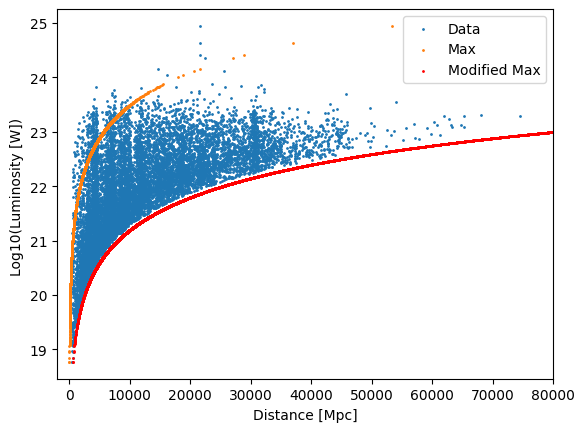

In [99]:
z = z[mask]
f = f[mask] * 10 ** -32 * 0.3631 # uJy -> W/m^2/Hz

cosmo = FlatLambdaCDM(H0=70, Om0=0.3)
d = cosmo.luminosity_distance(z) # Mpc
d *= 3.086 * 10 ** 22 # Mpc -> m

l = 4 * np.pi * (d ** 2) * f # m^2 * W/m^2/Hz = W/Hz

f_lim = mag_lim * 10 ** -32 # uJy -> W/m^2/Hz
dmaxs = np.sqrt(l / (4 * np.pi * f_lim)) # sqrt((W/Hz) / (W/m^2/Hz)) = m
dmaxs *= 3.241 * 10 ** -23 # m -> Mpc

flim = mag_lim * 10 ** -32 * 0.005
dmaxs2 = np.sqrt(l / (4 * np.pi * flim)) # sqrt((W/Hz) / (W/m^2/Hz)) = m
dmaxs2 *= 3.241 * 10 ** -23 # m -> Mpc

l = np.log10(l) # W/Hz -> log10(Watts/Hz)

plt.scatter(d*3.241*10**-23, l, s=1, label='Data')
plt.scatter(dmaxs, l, s=1, label='Max')
plt.scatter(dmaxs2, l, s=1, label='Modified Max', color='r')
plt.xlabel('Distance [Mpc]')
plt.ylabel('Log10(Luminosity [W]) ')
plt.xlim(-2000, 80000)
plt.legend()
plt.show()

### Ks Band Luminosity without AB magnitude limit masking

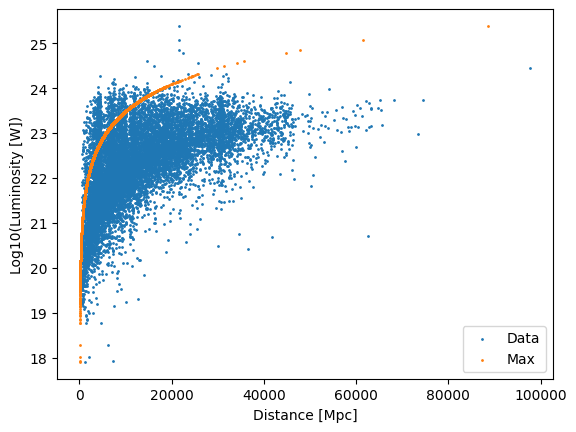

In [100]:
f = df['FKs'] # apparent magnitude
f *= 1e-32 # uJy -> W/m^2/Hz

f_lim = 25.9 # apparent magitude limit
f_lim *= 1e-32 # uJy -> W/m^2/Hz

z = df['zpk']
d = cosmo.luminosity_distance(z) # Mpc
d *= 3.086 * 10 ** 22 # Mpc -> m

l = 4 * np.pi * (d ** 2) * f # m^2 * W/m^2/Hz = W/Hz

dmaxs = np.sqrt(l / (4 * np.pi * f_lim)) # sqrt((W/Hz) / (W/m^2/Hz)) = m
dmaxs *= 3.241 * 10 ** -23 # m -> Mpc

l = np.log10(l) # W/Hz -> log10(Watts/Hz)

plt.scatter(d*3.241*10**-23, l, s=1, label='Data')
plt.scatter(dmaxs, l, s=1, label='Max')
plt.xlabel('Distance [Mpc]')
plt.ylabel('Log10(Luminosity [W])')
plt.legend()
plt.show()

### Bolometric Luminosity

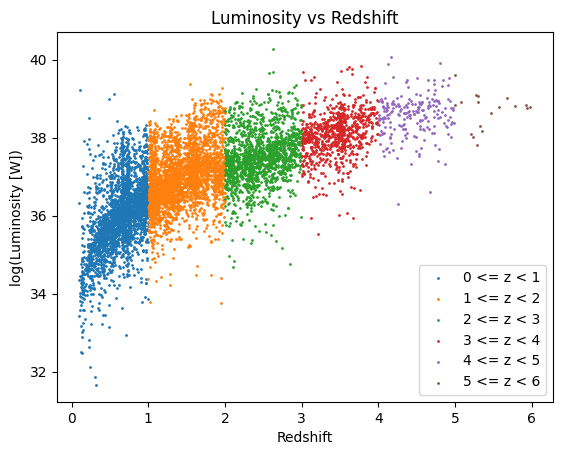

In [101]:
df = df[df['F24'] > 0] # 12,676 galaxies

lum = df['LIR'].copy() # solar luminosity
lum *= 3.828 * 10 ** 26 # solar luminosity -> Watts

z = df['zpk']

for z_start, z_end in z_bins:
    mask_z = (z >= z_start) & (z < z_end)
    plt.scatter(z[mask_z], np.log10(lum[mask_z]), s=1, label=f'{z_start} <= z < {z_end}')
plt.title('Luminosity vs Redshift')
plt.xlabel('Redshift')
plt.ylabel('log(Luminosity [W])')
plt.legend()
plt.show()

### Luminosity-Distance

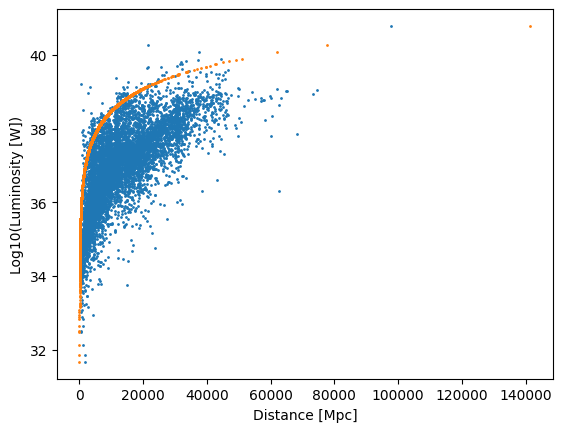

In [102]:
cosmo = FlatLambdaCDM(H0=70, Om0=0.3)
d = cosmo.luminosity_distance(z) # Mpc

f_lim = 25.9 # apparent magitude limit
# f_lim *= 1e-32 # uJy -> W/m^2/Hz
f_lim *= 10 ** -17 # uJy -> W/m^2/Hz

dmax = np.sqrt(lum / (4 * np.pi * f_lim)) # sqrt((W) / (W/m^2/Hz)) = m/sqrt(Hz)
dmax *= 3.241 * 10 ** -23 # m/sqrt(Hz) -> Mpc/sqrt(Hz)

plt.scatter(d, np.log10(lum), s=1)
plt.scatter(dmax, np.log10(lum), s=1)
plt.xlabel('Distance [Mpc]')
plt.ylabel('Log10(Luminosity [W])')
plt.show()

### New F24 Limit & Luminosity-Distance

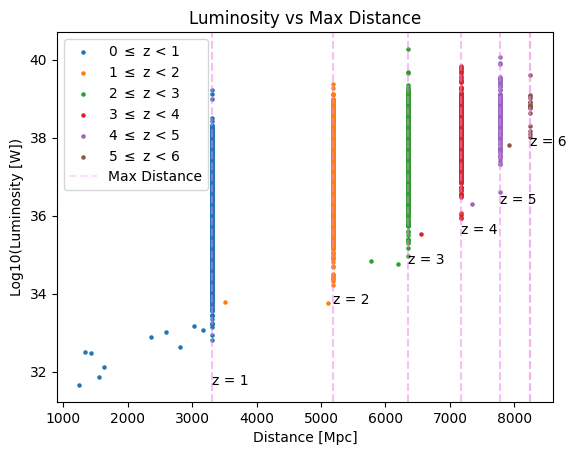

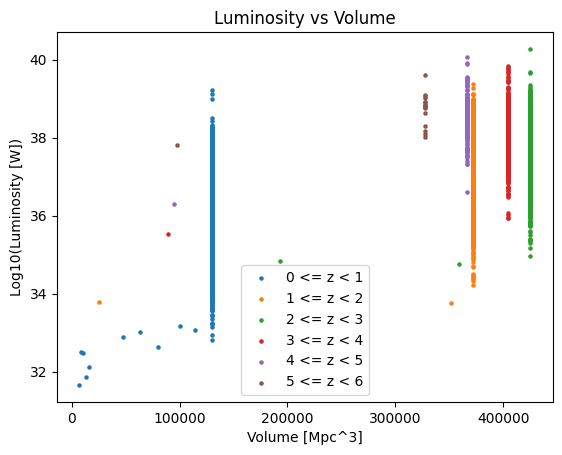

In [103]:
data = []
lum_limits = []
f = df['F24']

for z_start, z_end in z_bins:
    mask_z = (z >= z_start) & (z < z_end)
    
    # Redshift bin distance limits
    dmin = cosmo.comoving_distance(z_start) # Mpc
    dmax = cosmo.comoving_distance(z_end) # Mpc
    
    # Distance to each galaxy
    d = cosmo.comoving_distance(z[mask_z]) # Mpc
    
    # From the minimum detectable flux in the redshift bin, get the minimum luminosity 
    lum_min = lum[mask_z].values[np.argmin(f[mask_z])]
    z_lim = z[mask_z].values[np.argmin(f[mask_z])]
    lum_limits.append([z_lim, lum_min])
    
    # Calculate the maximum distance to each galaxy given the minimum detectable luminosity
    dmaxs = d * np.sqrt(lum[mask_z] / lum_min)
    
    # Set the maximum distance to the maximum redshift bin distance
    dmaxs.values[dmaxs > dmax] = dmax
    
    # Remove galaxies with maximum distance less than minimum distance
    mask_d = dmaxs > dmin
    dmaxs = dmaxs[mask_d]
    lum_bin = lum[mask_z & mask_d]
    
    # Calculate the minimum volume of the redshift bin
    vmin = 4/3 * np.pi * dmin**3 # Mpc^3

    # Calculate the maximum volume of each galaxy
    vmaxs = 4/3 * np.pi * dmaxs**3 # Mpc^3
    
    # Total volume probed accounting for survey area
    vol = (vmaxs - vmin) * (survey_area / 41253) # Mpc^3
    
    data.append([vol, np.log10(lum_bin)])
    
    plt.axvline(dmax.value, color='violet', linestyle='--', alpha=0.5)
    plt.scatter(dmaxs, np.log10(lum_bin), s=5, label=f'{z_start} $\leq$ z < {z_end}')
    plt.text(dmax.value, min(np.log10(lum_bin)), f'z = {z_end}')
    
plt.axvline(dmax.value, color='violet', linestyle='--', alpha=0.25, label='Max Distance')
plt.title('Luminosity vs Max Distance')
plt.xlabel('Distance [Mpc]')
plt.ylabel('Log10(Luminosity [W])')
plt.legend()
plt.show()

for (z_start, z_end), (v, l) in zip(z_bins, data):
    plt.scatter(v, l, s=5, label=f'{z_start} <= z < {z_end}')
plt.title('Luminosity vs Volume')
plt.xlabel('Volume [Mpc^3]')
plt.ylabel('Log10(Luminosity [W])')
plt.legend()
plt.show()